<a href="https://colab.research.google.com/github/JeroenVanB/FruitClassification/blob/main/classify_fruit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fruit classification
## Refrences:
- https://www.tensorflow.org/tutorials/load_data/images
- https://www.tensorflow.org/tutorials/images/classification
- https://www.tensorflow.org/tutorials/images/transfer_learning
- https://www.kaggle.com/moltean/fruits


###Initialization Variables


In [21]:
architecture = 3 # where:
  # 1 = MobileNetV2
  # 2 = InceptionV3
  # 3 = ResNet50
  # 4 = VGG19


###Preprocessing


In [22]:
USING_COLAB = True
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
import pathlib

In [23]:
if USING_COLAB:
  from google.colab import drive
  drive.mount("/content/gdrive")
  !unzip '/content/gdrive/My Drive/Deep Learning/Dataset.zip'

data_dir = 'Dataset/'


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
Archive:  /content/gdrive/My Drive/Deep Learning/Dataset.zip
replace Dataset/.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [24]:
train_dir = pathlib.Path(data_dir + 'Train')
BATCH_SIZE = 32
IMG_SIZE = (100,100)


train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    shuffle=True,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    shuffle=True,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    pathlib.Path(data_dir + 'Test'),
    shuffle=True,
    seed=123,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE)

class_names = train_ds.class_names
print(class_names)
num_of_classes = len(class_names)


Found 33940 files belonging to 11 classes.
Using 27152 files for training.
Found 33940 files belonging to 11 classes.
Using 6788 files for validation.
Found 11357 files belonging to 11 classes.
['Apples', 'Bananas', 'Cherries', 'Grapes', 'Onions', 'Peaches', 'Pears', 'Peppers', 'Plums', 'Potatoes', 'Tomatoes']


###Visualize data

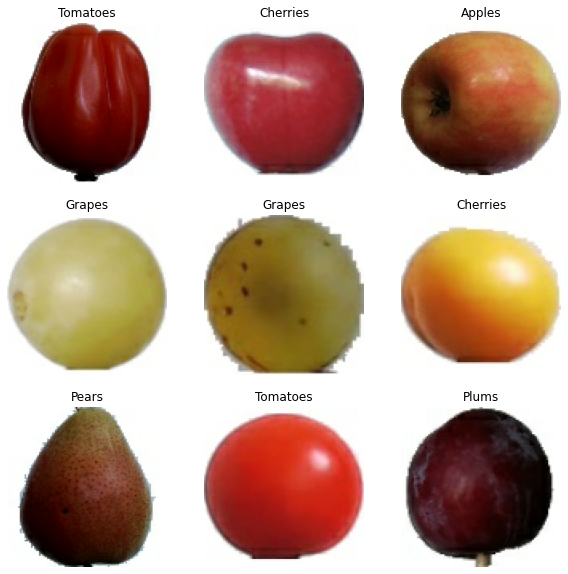

In [25]:
def plot_images():
    plt.figure(figsize=(10, 10))
    for images, labels in train_ds.take(1):
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.title(class_names[labels[i]])
            plt.axis("off")
plot_images()

###Data performance/caching and augmentation

In [26]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

train_ds = train_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

(32, 100, 100, 3)
(32,)


In [27]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

### Setup and training

In [28]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

IMG_SHAPE = IMG_SIZE + (3,)

if architecture == 1: # MobileNetV2
  preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
  base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                                include_top=False,
                                                weights='imagenet')
elif architecture == 2: # Inception V3
  preprocess_input = tf.keras.applications.inception_v3.preprocess_input
  base_model = tf.keras.applications.InceptionV3(input_shape=IMG_SHAPE,
                                                include_top=False,
                                                weights='imagenet')
elif architecture == 3: # ResNet50
  preprocess_input = tf.keras.applications.resnet.preprocess_input
  base_model = tf.keras.applications.ResNet50(input_shape=IMG_SHAPE,
                                                include_top=False,
                                                weights='imagenet')
elif architecture == 4: # VGG19
  pass

# This feature extractor will convert each 100x100x3 image into a 5x5x1280 block of features
image_batch, label_batch = next(iter(train_ds))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

base_model.trainable = False

global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

prediction_layer = tf.keras.layers.Dense(num_of_classes,)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 4, 4, 2048)
(32, 2048)
(32, 11)


####Important note about BatchNormalization layers
[TF Source.](https://www.tensorflow.org/tutorials/images/transfer_learning#important_note_about_batchnormalization_layers)
Many models contain tf.keras.layers.BatchNormalization layers. This layer is a special case and precautions should be taken in the context of fine-tuning, as shown later in this tutorial.

When you set layer.trainable = False, the BatchNormalization layer will run in inference mode, and will not update its mean and variance statistics.

When you unfreeze a model that contains BatchNormalization layers in order to do fine-tuning, you should keep the BatchNormalization layers in inference mode by passing training = False when calling the base model. Otherwise, the updates applied to the non-trainable weights will destroy what the model has learned.

In [29]:
inputs = tf.keras.Input(shape=(100, 100, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

model.compile(
  optimizer=tf.keras.optimizers.Adam(lr=0.0001),
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 100, 100, 3)]     0         
_________________________________________________________________
sequential_4 (Sequential)    (None, 100, 100, 3)       0         
_________________________________________________________________
tf.__operators__.getitem (Sl (None, 100, 100, 3)       0         
_________________________________________________________________
tf.nn.bias_add (TFOpLambda)  (None, 100, 100, 3)       0         
_________________________________________________________________
resnet50 (Functional)        (None, 4, 4, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 2048)              0   

In [30]:
initial_epochs = 10

# Evaluation before training (val_ds)
loss0, accuracy0 = model.evaluate(val_ds)
print("initial loss (on val_ds): {:.2f}".format(loss0))
print("initial accuracy (on val_ds): {:.2f}".format(accuracy0))

# Training the model
history = model.fit(train_ds,
                    epochs=initial_epochs,
                    validation_data=val_ds)

# Evaluation after training (val_ds)
loss1, accuracy1 = model.evaluate(val_ds)
print("after training loss (on val_ds): {:.2f}".format(loss1))
print("after training accuracy (on val_ds): {:.2f}".format(accuracy1))

213/213 [==============================] - 10s 39ms/step - loss: 4.0633 - accuracy: 0.0555
initial loss (on val_ds): 4.01
initial accuracy (on val_ds): 0.06
Epoch 1/10
849/849 [==============================] - 37s 40ms/step - loss: 1.0533 - accuracy: 0.6539 - val_loss: 0.3921 - val_accuracy: 0.8885
Epoch 2/10
849/849 [==============================] - 32s 38ms/step - loss: 0.3457 - accuracy: 0.8928 - val_loss: 0.2099 - val_accuracy: 0.9487
Epoch 3/10
849/849 [==============================] - 32s 38ms/step - loss: 0.2120 - accuracy: 0.9390 - val_loss: 0.1426 - val_accuracy: 0.9682
Epoch 4/10
849/849 [==============================] - 33s 38ms/step - loss: 0.1519 - accuracy: 0.9588 - val_loss: 0.1013 - val_accuracy: 0.9803
Epoch 5/10
849/849 [==============================] - 32s 38ms/step - loss: 0.1137 - accuracy: 0.9715 - val_loss: 0.0789 - val_accuracy: 0.9835
Epoch 6/10
849/849 [==============================] - 32s 38ms/step - loss: 0.0875 - accuracy: 0.9791 - val_loss: 0.0635 - 

#### Learning curves plot

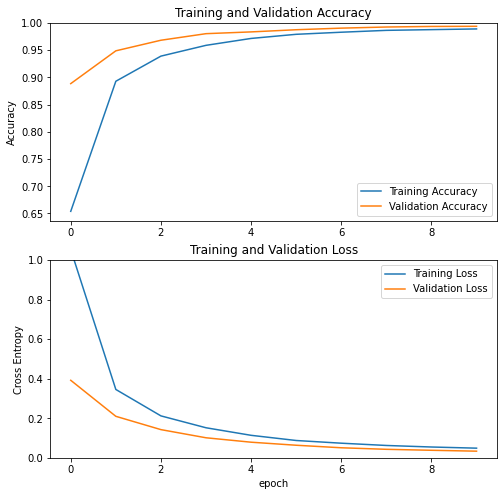

In [31]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

#### Important note about difference in validation metrics
If you are wondering why the validation metrics are clearly better than the training metrics, the main factor is because layers like tf.keras.layers.BatchNormalization and tf.keras.layers.Dropout affect accuracy during training. They are turned off when calculating validation loss.

To a lesser extent, it is also because training metrics report the average for an epoch, while validation metrics are evaluated after the epoch, so validation metrics see a model that has trained slightly longer.

[ 3  0  6  7  0  0 10  2  0  2  5  3  9  6  0  7  2  0  6  4  4 10  3  2
  0 10  1  2 10  0  2 10]


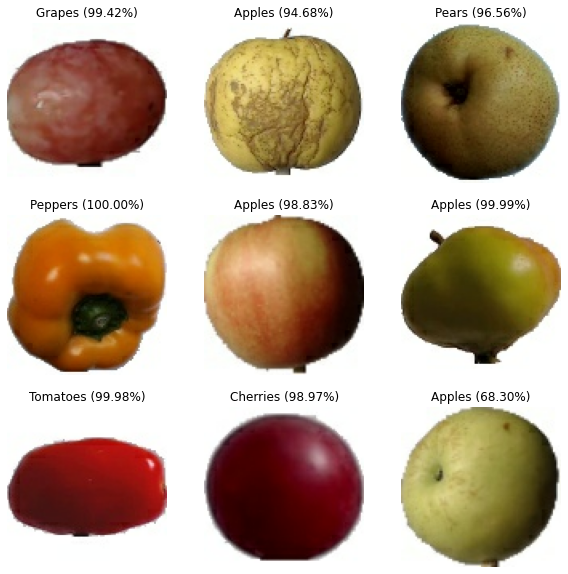

In [32]:
#Retrieve a batch of images from the test set
image_batch, label_batch = test_ds.as_numpy_iterator().next()
print(label_batch)
predictions = model.predict_on_batch(image_batch)
score = tf.nn.softmax(predictions[0])

# print(label_batch[0])
# print(score)

# print(
#     "This image most likely belongs to {} with a {:.2f} percent confidence."
#     .format(class_names[np.argmax(score)], 100 * np.max(score))
# )

plt.figure(figsize=(10, 10))
for i in range(9):
  score = tf.nn.softmax(predictions[i])
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[np.argmax(score)] + ' ({:.2f}%)'.format(100 * np.max(score)))
  plt.axis("off")

